In [19]:
import json

import torch
from torchvision.utils import make_grid
from torchvision import transforms
import matplotlib.pyplot as plt
from omegaconf import OmegaConf
from collections import OrderedDict

from datasets import get_CIFAR10, get_SVHN, postprocess, preprocess, get_CELEBA
from model import Glow


device = torch.device("cuda")

output_folder = 'output/'

conf = OmegaConf.load('config_train.yaml')    
image_shape, num_classes, celeba_data, celeba = get_CELEBA(conf.augment, conf.dataroot, True)
#image_shape, num_classes, _, test_svhn = get_SVHN(conf.augment, conf.dataroot, conf.download)

Files already downloaded and verified
Files already downloaded and verified


In [82]:
print(image_shape)

(128, 128, 3)


In [3]:
model_name = './mike_weights/epoch=6.ckpt'
checkpoint = torch.load(model_name, map_location=device)

## CHECK SAMPLING

In [4]:
model = Glow(image_shape, conf.hidden_channels, conf.K, conf.L, conf.actnorm_scale,
             conf.flow_permutation, conf.flow_coupling, conf.LU_decomposed, num_classes,
             conf.learn_top, conf.y_condition)

In [5]:
keys_orig = list(model.state_dict().keys())
keys_pl =  list(checkpoint['state_dict'].keys())
#keys_pl = [k.replace('model.','') for k in keys_pl]

In [67]:
#set(keys_pl).intersection(set(keys_orig))

In [6]:
print(len(keys_pl), len(keys_orig))

1540 1540


In [11]:
new_state_dict = OrderedDict()

for key, value in checkpoint['state_dict'].items():
    new_key = key.replace('model.','')
    new_state_dict[new_key] = value

In [12]:
keys_orig[:2]

['prior_h', 'flow.layers.1.actnorm.bias']

In [13]:
keys_pl[:2]

['model.prior_h', 'model.flow.layers.1.actnorm.bias']

In [14]:
model = Glow(image_shape, conf.hidden_channels, conf.K, conf.L, conf.actnorm_scale,
             conf.flow_permutation, conf.flow_coupling, conf.LU_decomposed, num_classes,
             conf.learn_top, conf.y_condition)

model.load_state_dict(new_state_dict)
model.set_actnorm_init()

model = model.to(device)

model = model.eval()

In [15]:
def sample(model):
    with torch.no_grad():
        if conf.y_condition:
            y = torch.eye(num_classes)
            y = y.repeat(batch_size // num_classes + 1)
            y = y[:32, :].to(device) # number hardcoded in model for now
        else:
            y = None

        images = postprocess(model(y_onehot=y, temperature=0.8, reverse=True))
    return images.cpu()

In [16]:
def min_max(arr):
    mn = arr.min()
    mx = arr.max()
    return (arr - mn)/(mx-mn)

(-0.5, 781.5, 651.5, -0.5)

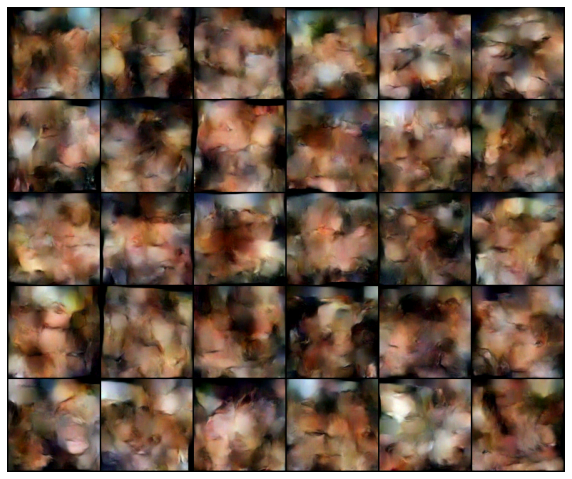

In [17]:
images = sample(model)
grid = make_grid(images[:30], nrow=6, normalize=False).permute(1,2,0).numpy()

plt.figure(figsize=(10,10))
plt.imshow(min_max(grid))
plt.axis('off')

# CHECK DIRECT FLOW

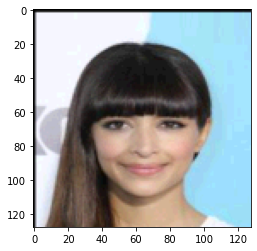

In [117]:
idx = 120
plt.imshow(min_max(celeba_data[idx][0].permute(1,2,0).numpy()))

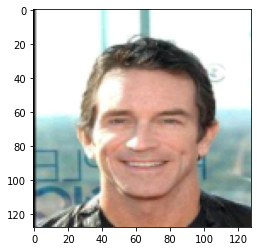

In [114]:
idx = 37
plt.imshow(min_max(celeba_data[idx][0].permute(1,2,0).numpy()))

In [8]:
convert_to_tensor = transforms.ToTensor()

In [34]:
# img_tensor =  preprocess(celeba_data[idx][0]).unsqueeze(0)
# print(f'tensor shape {img_tensor.shape}')

tensor shape torch.Size([1, 3, 128, 128])


In [36]:
# img_from_tensor = img_tensor.squeeze(0).permute(1,2,0).numpy()
# plt.imshow(min_max(img_from_tensor))

In [125]:
img_tensor = celeba_data[120][0].to(device).unsqueeze(0)
woman, _, _ = model(x=img_tensor, reverse=False)
img_tensor = celeba_data[37][0].to(device).unsqueeze(0)
man, _, _ = model(x=img_tensor, reverse=False)
print(f'Out shape: {z.shape}')
print(f'Out shape: {z.shape}')

Out shape: torch.Size([1, 192, 16, 16])
Out shape: torch.Size([1, 192, 16, 16])


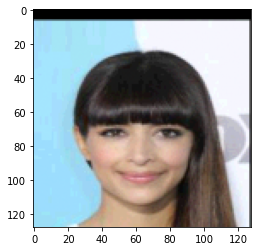

In [126]:
woman_back =  model(z=woman, y_onehot=None, temperature=None, reverse=True)
woman_from_tensor = woman_back.squeeze(0).permute(1,2,0).cpu().numpy()
plt.imshow(min_max(woman_from_tensor))

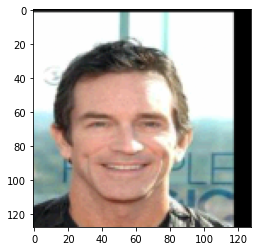

In [127]:
woman_back =  model(z=man, y_onehot=None, temperature=None, reverse=True)
woman_from_tensor = woman_back.squeeze(0).permute(1,2,0).cpu().numpy()
plt.imshow(min_max(woman_from_tensor))

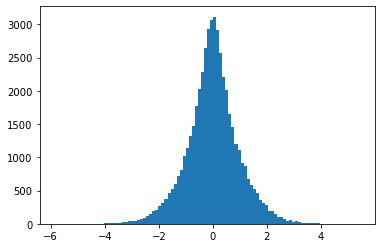

In [128]:
man.shape
plt.hist(man.squeeze(0).permute(1,2,0).detach().cpu().numpy().reshape(-1), bins=100);

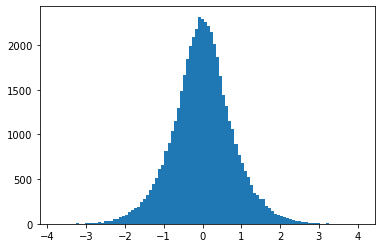

In [129]:
plt.hist(woman.squeeze(0).permute(1,2,0).detach().cpu().numpy().reshape(-1), bins=100);

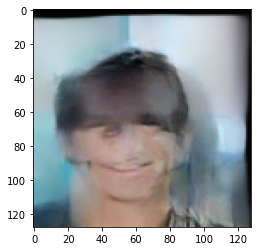

In [132]:
new_z = (0.5*woman.reshape(-1) + 0.5*man.reshape(-1)).reshape(1, 192, 16, 16)
z_back =  model(z=new_z, y_onehot=None, temperature=None, reverse=True)
z_from_tensor = z_back.squeeze(0).permute(1,2,0).cpu().numpy()
plt.imshow(min_max(z_from_tensor))